In [10]:
import os
import numpy as np
import pandas as pd
import joblib as jl
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [29]:
data = pd.read_csv('DummiesV2.csv')

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
targets = ['Indemne', 'Blessé léger', 'Blessé hospitalisé', 'Tué']
X = data.drop(targets, axis=1)
X = pd.DataFrame(data=StandardScaler().fit_transform(X), columns=X.columns)
Y = data[targets].values.argmax(axis=1) # cela réordonne bien les modalités puisque `targets` est ordonnée.
X_train, X_test,Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

# Avec une régression logistique

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE, RFECV

retrain = False
if not os.path.isfile('reglog.joblib') or retrain:
    estimator = LogisticRegression(multi_class='multinomial', max_iter=2_000)
    selector = RFECV(estimator, cv=StratifiedKFold(2), scoring="accuracy", step=1)
    selector = selector.fit(X_train, Y_train)
    #jl.dump(selector, 'reglog.joblib')
else:
    selector = jl.load('reglog.joblib')

In [33]:
selected = [variable for variable, boolean in zip(X.columns.tolist(), selector.support_.tolist()) if boolean]
print('Accuracy :', np.mean(selector.estimator_.predict(X_test[selected]) == Y_test))

Accuracy : 0.650520597555455


In [35]:
def plot_confusion_matrix(matrix, classes,
                          normalize=False,
                          cmap=plt.cm.Blues,
                          title=None):

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
        title = title if title else "Normalized confusion matrix"
    else:
        title = title if title else "Raw confusion matrix"

    sns.set_style('ticks')
    res = sns.heatmap(matrix,
                      cmap=cmap,
                      cbar=True,
                      square=True,
                      annot=True)

    for _, spine in res.spines.items():
        spine.set_visible(True)

    plt.title(title)
    tick_marks = np.arange(len(classes)) + .5
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes, rotation=0)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

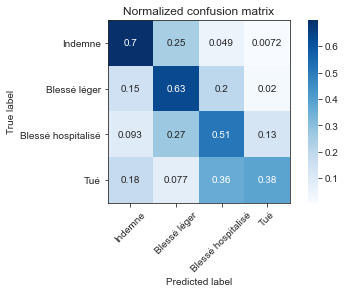

In [38]:
from sklearn import metrics
estimator = selector.estimator_
conf = metrics.confusion_matrix(estimator.predict(X_test[selected]), Y_test)
plot_confusion_matrix(conf, classes=targets, normalize=True);

# Avec un Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier

retrain = False
if not os.path.isfile('randomforest.joblib') or retrain:
    estimator2 = RandomForestClassifier()
    selector2 = RFECV(estimator2, cv=StratifiedKFold(2), scoring="accuracy", step=1)
    selector2 = selector2.fit(X_train, Y_train)
    #jl.dump(selector2, 'randomforest.joblib')
else:
    selector2 = jl.load('randomforest.joblib')

In [40]:
estimator2 = selector2.estimator_
selected2 = [variable for variable, boolean in zip(X.columns.tolist(), selector2.support_.tolist()) if boolean]
print('Accuracy :', np.mean(estimator2.predict(X_test[selected2]) == Y_test))

Accuracy : 0.6555002263467632


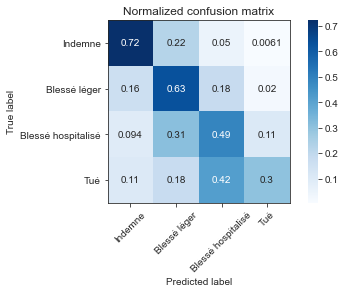

In [42]:
conf = metrics.confusion_matrix(estimator2.predict(X_test[selected2]), Y_test)
plot_confusion_matrix(conf, classes=targets, normalize=True);

# Avec un SVM

In [47]:
from sklearn.svm import SVC

retrain = True
if not os.path.isfile('svm.joblib') or retrain:
    estimator3 = SVC().fit(X_train, Y_train)
    selector3 = RFECV(estimator3, cv=StratifiedKFold(2), scoring="accuracy", step=1)
    selector3 = selector3.fit(X_train, Y_train)
    #jl.dump(selector3, 'svm.joblib')
else:
    selector3 = jl.load('svm.joblib')

ValueError: when `importance_getter=='auto'`, the underlying estimator SVC should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.

In [ ]:
selected3 = [variable for variable, boolean in zip(X.columns.tolist(), selector3.support_.tolist()) if boolean]
estimator3 = selector3.estimator_
print('Accuracy :', np.mean(selector3.estimator_.predict(X_test[selected3]) == Y_test))

In [ ]:
conf = metrics.confusion_matrix(estimator3.predict(X_test[selected]), Y_test)
plot_confusion_matrix(conf, classes=targets, normalize=True);